In [1]:
import numpy as np

In [2]:
from scipy import stats

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('darkgrid')
%matplotlib inline

## I. Exponential distribution

### Генерація даних з параметром $\lambda$ = 10

#### 1. Згенеруємо $N$ випадкових, рівномірно розподілених в інтервалі (0, 1) чисел $\epsilon_i$

In [5]:
n = 10000
lambda_1 = 10

In [6]:
epsilon_uniform = np.random.uniform(low=0, high=1, size=n)

**Побудуємо гістрограму даного розподілу:**

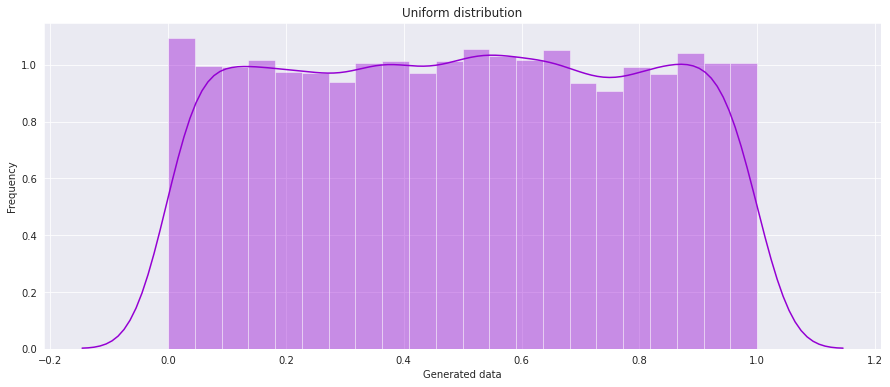

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(epsilon_uniform, ax=ax, color='darkviolet')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Uniform distribution');

+ розподіл схожий на рівномірний
+ дані розподілені в інтервалі (0, 1)

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$M(\epsilon) = \int_0^1 x \,dx = \frac{1}{2}$

$D(\epsilon) = \int_0^1 (x - \frac{1}{2})^2 \,dx = \frac{1}{12}$

In [8]:
print('M(epsilon) = %s\nD(epsilon) = %s' % (epsilon_uniform.mean(), epsilon_uniform.std(ddof=1)**2))

M(epsilon) = 0.49835539810821383
D(epsilon) = 0.08384554521014828


+ значення математичного очікування та дисперсії подібні до теоретичних

#### 2. Згенеруємо $N$ чисел $x_i$ з експоненційного розподілу

In [9]:
x_exp = -np.log(epsilon_uniform) / lambda_1

**Побудуємо гістрограму та KDE plot для згенерованих даних**

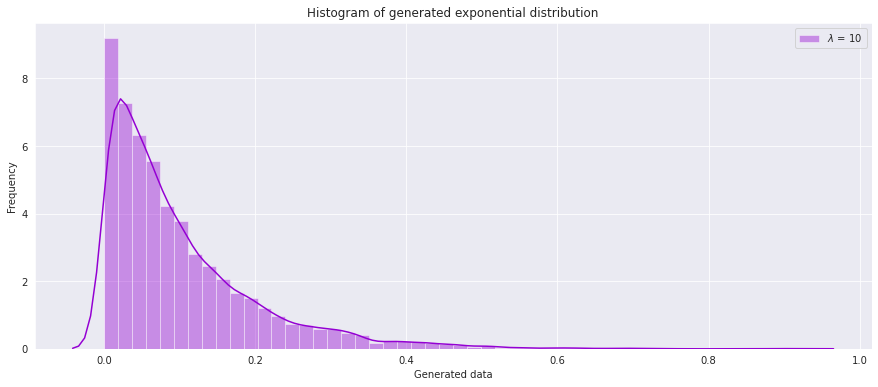

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(x_exp, ax=ax, color='darkviolet', label=f'$\lambda$ = {lambda_1}')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Histogram of generated exponential distribution');
ax.legend();

+ розподіл даних подібний до експоненційного

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$\mu = \frac{1}{\lambda}$

$D(x) = \sigma^2$, де $\sigma = \frac{1}{\lambda}$

In [11]:
print('M(x) = %s\nstd(x) = %s\nD(x) = %s' % (x_exp.mean(), x_exp.std(ddof=1), x_exp.std(ddof=1)**2))

M(x) = 0.10105582810042764
std(x) = 0.10127623014133887
D(x) = 0.010256874791641436


+ математичне сподівання приблизно дорівнює стандартному квадратичному відхиленню

#### 3. Виконаємо перевірку на відповідність експоненційному закону розподілу, використавши формулу:

$F(x) = 1 - e^{-\lambda x}$

In [12]:
def exp_cdf(x, l):
    """
        Cumulative distribution function 
    """
    return 1 - np.exp(-l*x) # F


def exp_pdf(x, l):
    """
        Probability density function
    """
    return l*np.exp(-l*x) # f

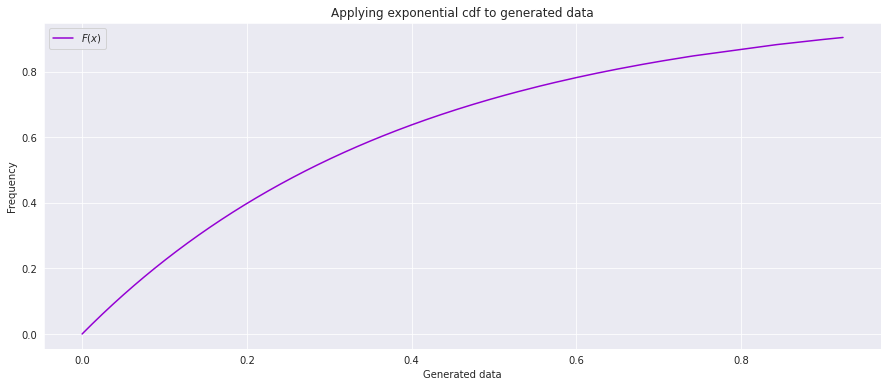

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

x = np.linspace(0,1,100000)
sns.lineplot(x_exp, exp_cdf(x_exp, 1/((x.mean() + x.std(ddof=1)) / 2)), ax=ax, color='darkviolet', label='$F(x)$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Applying exponential cdf to generated data');
ax.legend();

#### 4. Відповідність заданому закону розподілу перевірити за допомогою критерію $\chi^2$

$H_0:$ дані мають експоненційний розподіл з заданим параметром $\lambda$

$H_1: H_0$ не виконується

In [14]:
def create_bins_expon(x, n_bins=30):
    start = x.min()
    finish = x.max() + 1e-9
    h = (finish - start) / n_bins
    n = x.size
    l = 1/((x.mean() + x.std(ddof=1)) / 2)
    
    obs_freq = {}
    exp_freq = {}
    
    current = start

    i = 0
    while current <= finish:
        obs_freq[i] = np.sum((x >= current) & (x < (current+h)))
        p_i = np.exp(-l*current) - np.exp(-l*(current+h))
        exp_freq[i] = p_i * n
        i += 1
        current += h
    return normilize_bins_expon(obs_freq, exp_freq)

In [15]:
def normilize_bins_expon(obs_freq, exp_freq):
    assert len(obs_freq) > 2 or len(exp_freq) > 2

    for i in sorted(obs_freq.keys(), reverse=True)[:-1]:
        if obs_freq[i] <= 5 or exp_freq[i] <= 5:
            obs_freq[i-1] += obs_freq[i]
            exp_freq[i-1] += exp_freq[i]
            del obs_freq[i], exp_freq[i]
            
    return obs_freq, exp_freq

In [16]:
observed_freq, expected_freq = create_bins_expon(x_exp)

In [17]:
stat_val, p_value = stats.chisquare(list(observed_freq.values()), list(expected_freq.values()), ddof=1)

+ **Ймовірність отримати значення статистики як в експерименті чи ще більше екстримальне при справедливості нульової гіпотези**
+ **Чим нижче p-value, тим сильніше дані свідчать проти прийняття нульової гіпотези на користь альтернативи**

$p = P(T \geq t|H_0)$

In [18]:
alpha = 0.05
if p_value < alpha:
    print(f'Не можемо прийняти нульову гіпотезу на рівні значемості alpha={alpha}.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))
else:
    print('Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))

Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.
Значення статистики:
	- stat_val = 25.91212
	- p-value = 0.16873


### Генерація даних з параметром $\lambda$ = 1.2

#### 1. Згенеруємо $N$ випадкових, рівномірно розподілених в інтервалі (0, 1) чисел $\epsilon_i$

In [19]:
n = 10000
lambda_2 = 1.2

In [20]:
epsilon_uniform = np.random.uniform(low=0, high=1, size=n)

**Побудуємо гістрограму даного розподілу:**

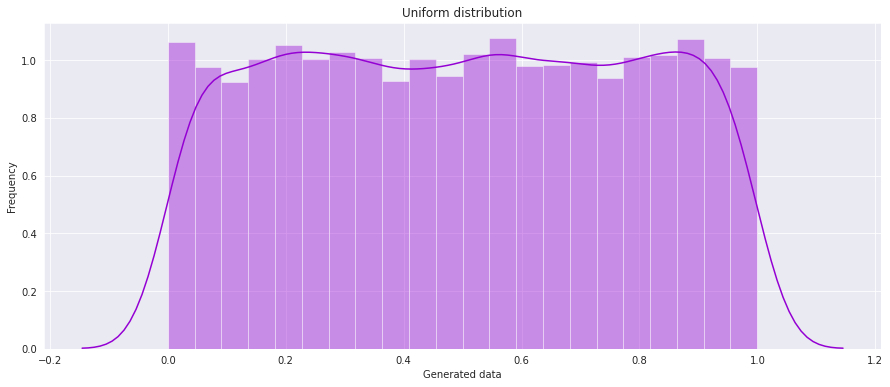

In [21]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(epsilon_uniform, ax=ax, color='darkviolet')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Uniform distribution');

+ розподіл схожий на рівномірний
+ дані розподілені в інтервалі (0, 1)

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$M(\epsilon) = \int_0^1 x \,dx = \frac{1}{2}$

$D(\epsilon) = \int_0^1 (x - \frac{1}{2})^2 \,dx = \frac{1}{12}$

In [22]:
print('M(epsilon) = %s\nD(epsilon) = %s' % (epsilon_uniform.mean(), epsilon_uniform.std(ddof=1)**2))

M(epsilon) = 0.5003601385488841
D(epsilon) = 0.08349922900382829


+ значення математичного очікування та дисперсії подібні до теоретичних

#### 2. Згенеруємо $N$ чисел $x_i$ з експоненційного розподілу

In [23]:
x_exp = -np.log(epsilon_uniform) / lambda_2

**Побудуємо гістрограму та KDE plot для згенерованих даних**

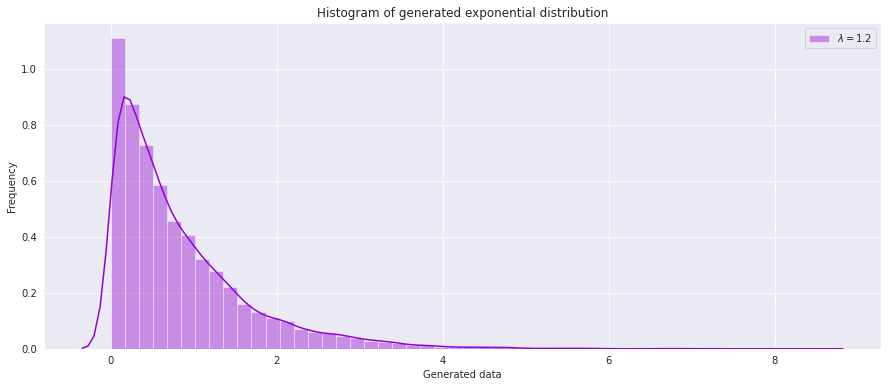

In [24]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(x_exp, ax=ax, color='darkviolet', label=f'$\lambda = {lambda_2}$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Histogram of generated exponential distribution');
ax.legend();

+ розподіл даних подібний до експоненційного

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$\mu = \frac{1}{\lambda}$

$D(x) = \sigma^2$, де $\sigma = \frac{1}{\lambda}$

In [25]:
print('M(x) = %s\nstd(x) = %s\nD(x) = %s' % (x_exp.mean(), x_exp.std(ddof=1), x_exp.std(ddof=1)**2))

M(x) = 0.8329409638365456
std(x) = 0.8321843359835084
D(x) = 0.6925307690563127


+ математичне сподівання приблизно дорівнює стандартному квадратичному відхиленню

#### 3. Виконаємо перевірку на відповідність експоненційному закону розподілу, використавши формулу:

$F(x) = 1 - e^{-\lambda x}$

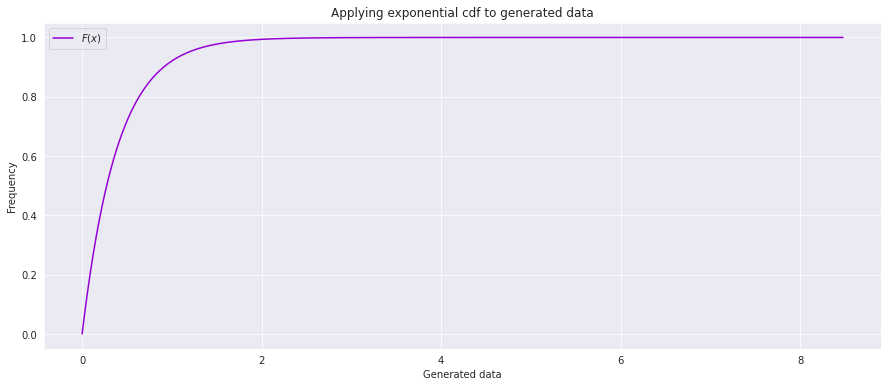

In [26]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

x = np.linspace(0,1,100000)
sns.lineplot(x_exp, exp_cdf(x_exp, 1/((x.mean() + x.std(ddof=1)) / 2)), ax=ax, color='darkviolet', label='$F(x)$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Applying exponential cdf to generated data');
ax.legend();

#### 4. Відповідність заданому закону розподілу перевірити за допомогою критерію $\chi^2$

$H_0:$ дані мають експоненційний розподіл з заданим параметром $\lambda$

$H_1: H_0$ не виконується

In [27]:
observed_freq, expected_freq = create_bins_expon(x_exp)

In [28]:
stat_val, p_value = stats.chisquare(list(observed_freq.values()), list(expected_freq.values()), ddof=1)

+ **Ймовірність отримати значення статистики як в експерименті чи ще більше екстримальне при справедливості нульової гіпотези**
+ **Чим нижче p-value, тим сильніше дані свідчать проти прийняття нульової гіпотези на користь альтернативи**

$p = P(T \geq t|H_0)$

In [29]:
alpha = 0.05
if p_value < alpha:
    print(f'Не можемо прийняти нульову гіпотезу на рівні значемості alpha={alpha}.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))
else:
    print('Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))

Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.
Значення статистики:
	- stat_val = 19.05179
	- p-value = 0.38864


****
****
****

## II. Normal distribution

### Генерація даних з параметром $\mu = 0, \sigma = 1$

#### 1. Згенеруємо $N$ випадкових, рівномірно розподілених в інтервалі (0, 1) чисел $\epsilon_i$

In [30]:
n = 10000
mu_1 = 0
sigma_1 = 1

In [31]:
epsilon_uniform = np.random.uniform(low=0, high=1, size=(n, 12))

**Побудуємо гістрограму даного розподілу:**

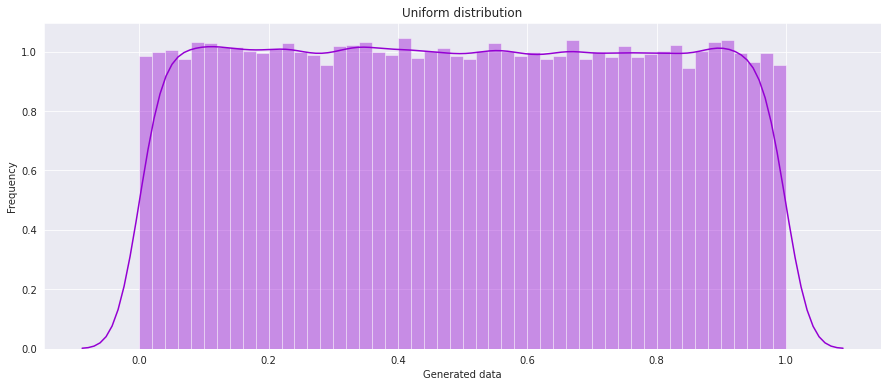

In [32]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(epsilon_uniform, ax=ax, color='darkviolet')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Uniform distribution');

+ розподіл схожий на рівномірний
+ дані розподілені в інтервалі (0, 1)

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$M(\epsilon) = \int_0^1 x \,dx = \frac{1}{2}$

$D(\epsilon) = \int_0^1 (x - \frac{1}{2})^2 \,dx = \frac{1}{12}$

In [33]:
print('M(epsilon) = %s\nD(epsilon) = %s' % (epsilon_uniform.mean(), epsilon_uniform.std(ddof=1)**2))

M(epsilon) = 0.4987438519920403
D(epsilon) = 0.08319176658612779


+ значення математичного очікування та дисперсії подібні до теоретичних

#### 2. Згенеруємо $N$ чисел $x_i$ з нормального розподілу

In [34]:
x_normal = sigma_1 * (epsilon_uniform.sum(axis=1) - 6) + mu_1

**Побудуємо гістрограму та KDE plot для згенерованих даних**

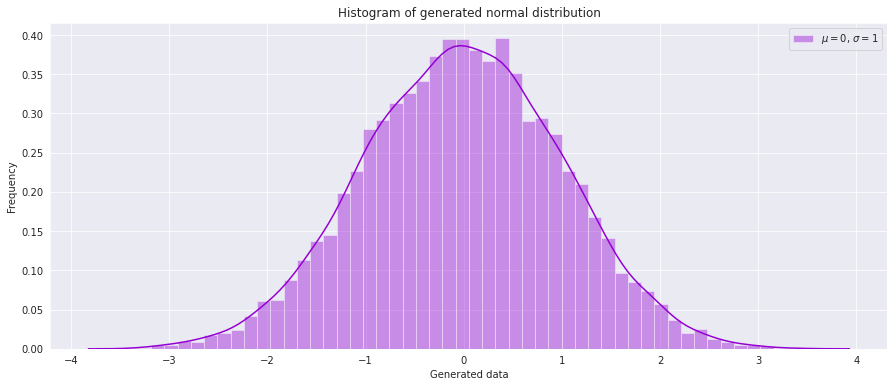

In [35]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(x_normal, ax=ax, color='darkviolet', label=f'$\mu = {mu_1}$, $\sigma = {sigma_1}$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Histogram of generated normal distribution');
ax.legend();

+ розподіл даних подібний до нормального з відповідними параметрами

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$\mu = \mu_1$

$D(x) = \sigma^2$, де $\sigma = \sigma_1$

In [36]:
print('M(x) = %s\nstd(x) = %s\nD(x) = %s' % (x_normal.mean(), x_normal.std(ddof=1), x_normal.std(ddof=1)**2))

M(x) = -0.015073776095516137
std(x) = 0.9994859274199858
D(x) = 0.998972119110589


+ параметри математичного сподівання та стандарного відхилення подібні до тих, які ми хотіли отримати

#### 3. Виконаємо перевірку на відповідність нормальному закону розподілу, використавши формулу:

$f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x - a)^2}{2 \sigma^2}}$

In [37]:
def normal_pdf(x, mu, sigma):
    """
        Probability density function
    """
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-np.power((x-mu)/sigma, 2)/2) # f

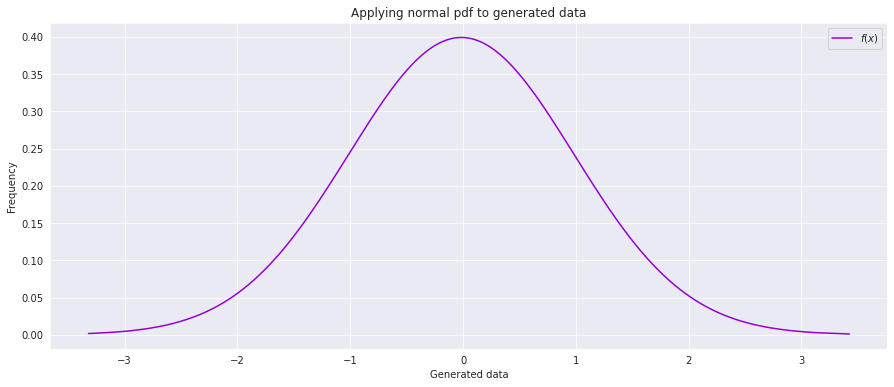

In [38]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

x = np.linspace(0,1,100000)
sns.lineplot(x_normal, normal_pdf(x_normal, x_normal.mean(), x_normal.std(ddof=1)), ax=ax, color='darkviolet', label='$f(x)$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Applying normal pdf to generated data');
ax.legend();

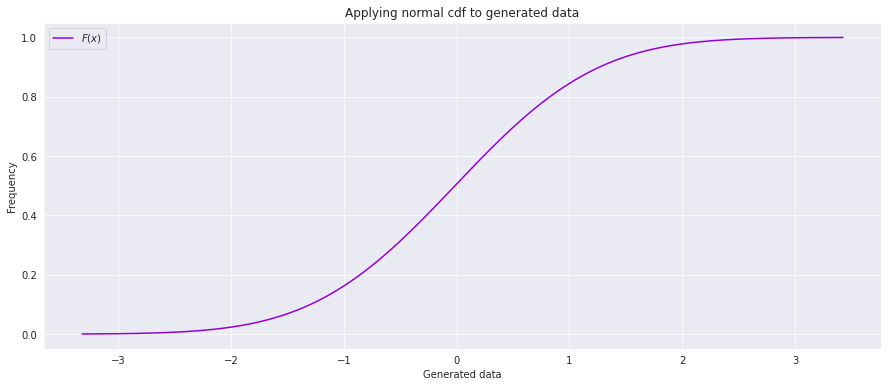

In [39]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

x = np.linspace(0,1,100000)
sns.lineplot(x_normal, stats.norm.cdf(x_normal, x_normal.mean(), x_normal.std(ddof=1)), ax=ax, color='darkviolet', label='$F(x)$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Applying normal cdf to generated data');
ax.legend();

#### 4. Відповідність заданому закону розподілу перевірити за допомогою критерію $\chi^2$

$H_0:$ дані мають нормальний розподіл з заданим параметром $\mu$ та $\sigma$

$H_1: H_0$ не виконується

In [40]:
def create_bins_norm(x, n_bins=30):
    start = x.min()
    finish = x.max() + 1e-9
    h = (finish - start) / n_bins
    n = x.size
    mu = x.mean()
    sigma = x.std(ddof=1)
    
    obs_freq = {}
    exp_freq = {}
    
    current = start

    i = 0
    while current <= finish:
        obs_freq[i] = np.sum((x >= current) & (x < (current+h)))
        p_i = np.abs(stats.norm(mu, sigma).cdf(current) - stats.norm(mu, sigma).cdf(current+h))
        exp_freq[i] = p_i * n
        i += 1
        current += h
    return normilize_bins_norm(obs_freq, exp_freq)

In [41]:
def normilize_bins_norm(obs_freq, exp_freq):
    assert len(obs_freq) > 2 or len(exp_freq) > 2
        
    for i in sorted(obs_freq.keys(), reverse=True)[:-1]:
        if obs_freq[i] <= 5 or exp_freq[i] <= 5:
            obs_freq[i-1] += obs_freq[i]
            exp_freq[i-1] += exp_freq[i]
            del obs_freq[i], exp_freq[i]
    
    for i in sorted(obs_freq.keys())[:-1]:
        if obs_freq[i] <= 5 or exp_freq[i] <= 5:
            j = 1
            while not i+j in obs_freq:
                j += 1
            obs_freq[i+j] += obs_freq[i]
            exp_freq[i+j] += exp_freq[i]
            del obs_freq[i], exp_freq[i]
    
    return obs_freq, exp_freq

In [42]:
observed_freq, expected_freq = create_bins_norm(x_normal)

In [43]:
stat_val, p_value = stats.chisquare(list(observed_freq.values()), list(expected_freq.values()), ddof=1)

+ **Ймовірність отримати значення статистики як в експерименті чи ще більше екстримальне при справедливості нульової гіпотези**
+ **Чим нижче p-value, тим сильніше дані свідчать проти прийняття нульової гіпотези на користь альтернативи**

$p = P(T \geq t|H_0)$

In [44]:
alpha = 0.05
if p_value < alpha:
    print(f'Не можемо прийняти нульову гіпотезу на рівні значемості alpha={alpha}.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))
else:
    print('Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))

Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.
Значення статистики:
	- stat_val = 23.78216
	- p-value = 0.64237


### Генерація даних з параметром $\mu = 12, \sigma = 24$

#### 1. Згенеруємо $N$ випадкових, рівномірно розподілених в інтервалі (0, 1) чисел $\epsilon_i$

In [45]:
n = 10000
mu_2 = 12
sigma_2 = 24

In [46]:
epsilon_uniform = np.random.uniform(low=0, high=1, size=(n, 12))

**Побудуємо гістрограму даного розподілу:**

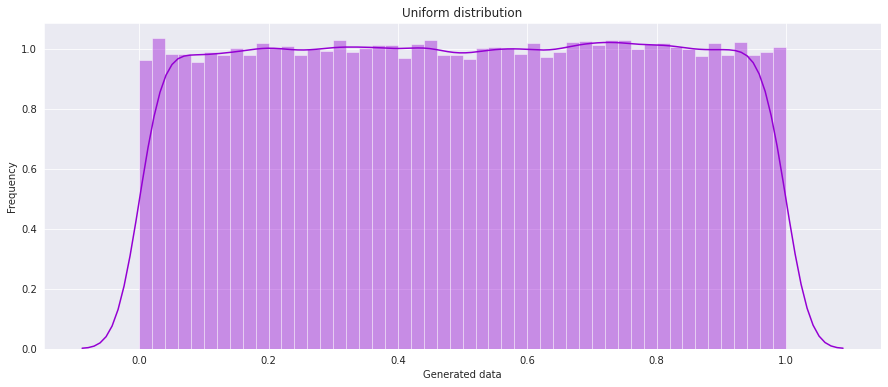

In [47]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(epsilon_uniform, ax=ax, color='darkviolet')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Uniform distribution');

+ розподіл схожий на рівномірний
+ дані розподілені в інтервалі (0, 1)

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$M(\epsilon) = \int_0^1 x \,dx = \frac{1}{2}$

$D(\epsilon) = \int_0^1 (x - \frac{1}{2})^2 \,dx = \frac{1}{12}$

In [48]:
print('M(epsilon) = %s\nD(epsilon) = %s' % (epsilon_uniform.mean(), epsilon_uniform.std(ddof=1)**2))

M(epsilon) = 0.5014225375228276
D(epsilon) = 0.08308218856820739


+ значення математичного очікування та дисперсії подібні до теоретичних

#### 2. Згенеруємо $N$ чисел $x_i$ з нормального розподілу

In [49]:
x_normal = sigma_2 * (epsilon_uniform.sum(axis=1) - 6) + mu_2

**Побудуємо гістрограму та KDE plot для згенерованих даних**

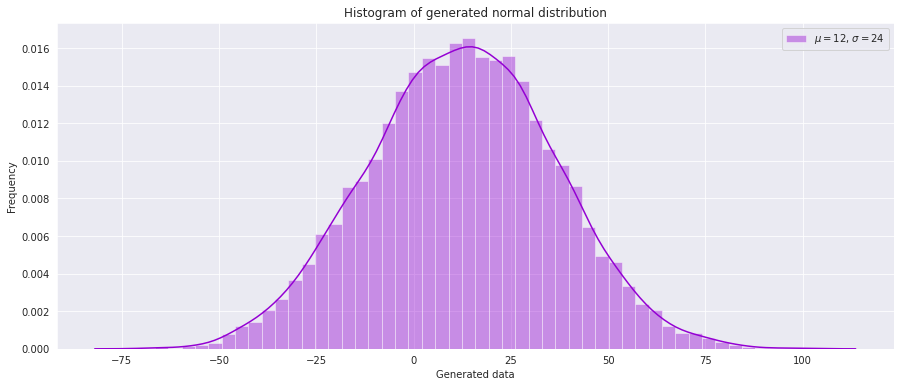

In [50]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(x_normal, ax=ax, color='darkviolet', label=f'$\mu = {mu_2}$, $\sigma = {sigma_2}$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Histogram of generated normal distribution');
ax.legend();

+ розподіл даних подібний до нормального з відповідними параметрами

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$\mu = \mu_1$

$D(x) = \sigma^2$, де $\sigma = \sigma_1$

In [51]:
print('M(x) = %s\nstd(x) = %s\nD(x) = %s' % (x_normal.mean(), x_normal.std(ddof=1), x_normal.std(ddof=1)**2))

M(x) = 12.40969080657437
std(x) = 23.892519357448815
D(x) = 570.8524812460663


+ параметри математичного сподівання та стандарного відхилення подібні до тих, які ми хотіли отримати

#### 3. Виконаємо перевірку на відповідність нормальному закону розподілу, використавши формулу:

$f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x - a)^2}{2 \sigma^2}}$

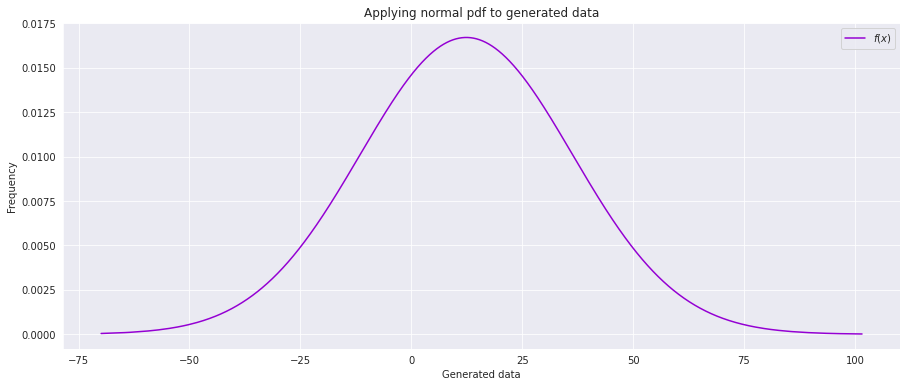

In [52]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

x = np.linspace(0,1,100000)
sns.lineplot(x_normal, normal_pdf(x_normal, x_normal.mean(), x_normal.std(ddof=1)), ax=ax, color='darkviolet', label='$f(x)$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Applying normal pdf to generated data');
ax.legend();

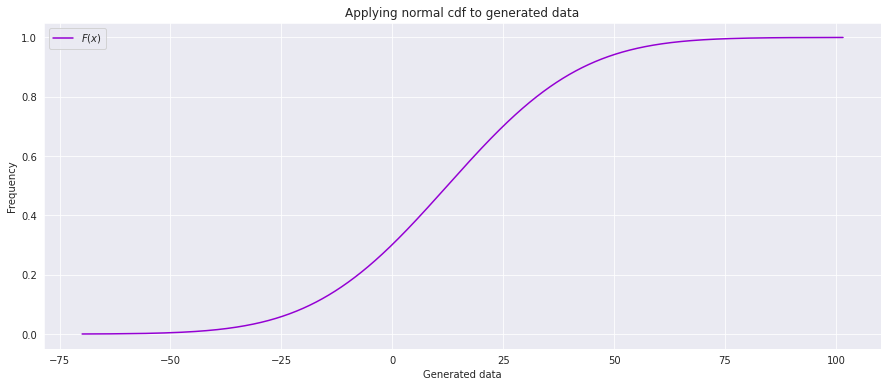

In [53]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

x = np.linspace(0,1,100000)
sns.lineplot(x_normal, stats.norm.cdf(x_normal, x_normal.mean(), x_normal.std(ddof=1)), ax=ax, color='darkviolet', label='$F(x)$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Applying normal cdf to generated data');
ax.legend();

#### 4. Відповідність заданому закону розподілу перевірити за допомогою критерію $\chi^2$

$H_0:$ дані мають нормальний розподіл з заданим параметром $\mu$ та $\sigma$

$H_1: H_0$ не виконується

In [98]:
observed_freq, expected_freq = create_bins_norm(x_normal)

In [99]:
stat_val, p_value = stats.chisquare(list(observed_freq.values()), list(expected_freq.values()), ddof=1)

+ **Ймовірність отримати значення статистики як в експерименті чи ще більше екстримальне при справедливості нульової гіпотези**
+ **Чим нижче p-value, тим сильніше дані свідчать проти прийняття нульової гіпотези на користь альтернативи**

$p = P(T \geq t|H_0)$

In [56]:
alpha = 0.05
if p_value < alpha:
    print(f'Не можемо прийняти нульову гіпотезу на рівні значемості alpha={alpha}.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))
else:
    print('Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))

Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.
Значення статистики:
	- stat_val = 27.36537
	- p-value = 0.33788


****
****
****

## III. Uniform distribution

### Генерація даних з параметром $a = 5^{13}, c = 2^{31}$

#### 1. Згенеруємо $N$ випадкових чисел, використовуючи конгруентний метод:

$x_{i+1} = z_{i+1} \div c$, де

$z_{i+1} = a z_i ($ mod $c)$

In [77]:
n = 10000

z_0 = 9
z = z_0
a = 5 ** 13
c = 2 ** 31
x_uniform = []

for i in range(n):
    x = z / c
    x_uniform.append(x)
    z = (a * z) % c
    
x_uniform = np.array(x_uniform)

**Побудуємо гістрограму даного розподілу:**

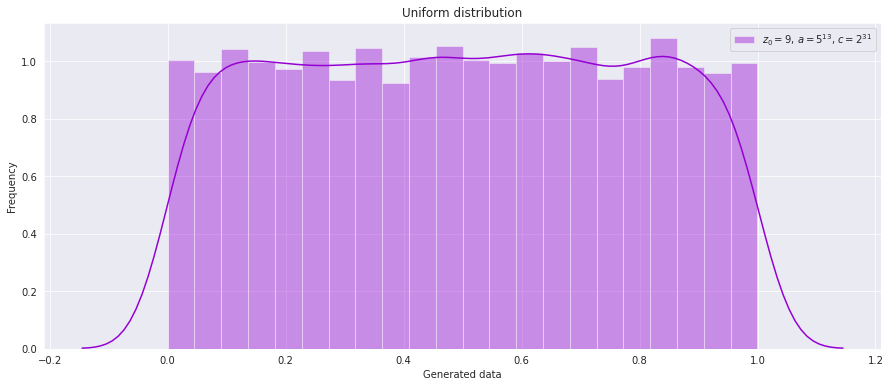

In [78]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(x_uniform, ax=ax, color='darkviolet', label='$z_0 = 9$, $a = 5^{13}$, $c = 2^{31}$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Uniform distribution');
ax.legend();

+ розподіл схожий на рівномірний
+ дані розподілені в інтервалі (0, 1)

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$M(\epsilon) = \int_0^1 x \,dx = \frac{1}{2}$

$D(\epsilon) = \int_0^1 (x - \frac{1}{2})^2 \,dx = \frac{1}{12}$

In [80]:
print('M(epsilon) = %s\nD(epsilon) = %s' % (x_uniform.mean(), x_uniform.std(ddof=1)**2))

M(epsilon) = 0.4999288878433406
D(epsilon) = 0.08299691989657997


+ значення математичного очікування та дисперсії подібні до теоретичних

**Давайте знайдемо параметри даного розподілу:**

In [101]:
b_obs = x_uniform.mean() + np.sqrt(3)*x_uniform.std(ddof=1)
a_obs = 2*x_uniform.mean() - b_obs

print(f'a_obs = {round(a_obs, 5)}, b_obs = {round(b_obs, 5)}')

a_obs = -0.00327, b_obs = 0.99985


#### 3. Виконаємо перевірку на відповідність нормальному закону розподілу, використавши формулу:

$f(x) = \frac{1}{b - a}$, $a \leq x \leq b$

In [82]:
def uniform_pdf(x, a, b):
    """
        Probability density function
    """
    return (1/(b-a))*((x >= a) & (x <= b)) # f

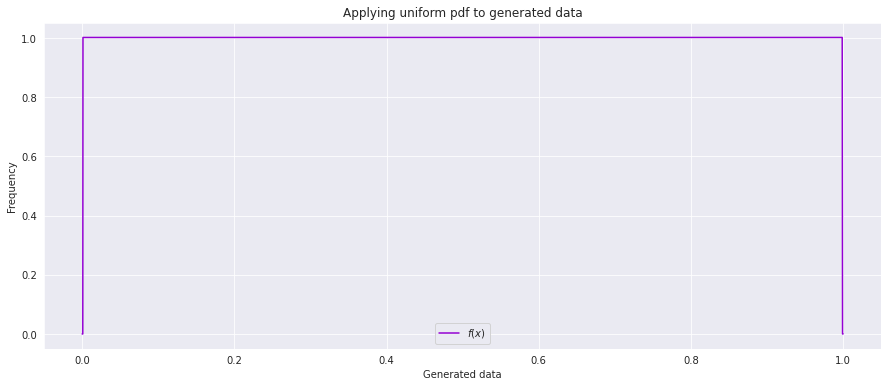

In [83]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

x = np.linspace(0,1,100000)
sns.lineplot(x_uniform, uniform_pdf(x_uniform, a_obs, b_obs), ax=ax, color='darkviolet', label='$f(x)$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Applying uniform pdf to generated data');
ax.legend();

#### 4. Відповідність заданому закону розподілу перевірити за допомогою критерію $\chi^2$

$H_0:$ дані мають рівномірний розподіл з заданим параметром $a$ та $b$

$H_1: H_0$ не виконується

In [84]:
def create_bins_uniform(x, n_bins=30):
    start = x.min()
    finish = x.max() + 1e-9
    h = (finish - start) / n_bins
    n = x.size
    b = (x.mean() + np.sqrt(3)*x.std(ddof=1))
    a = 2*x.mean() - b
    
    obs_freq = {}
    exp_freq = {}
    
    current = start

    i = 0
    while current <= finish:
        obs_freq[i] = np.sum((x >= current) & (x < (current+h)))
        p_i = np.abs(stats.uniform(a, b).cdf(current) - stats.uniform(a, b).cdf(current+h))
        exp_freq[i] = p_i * n
        i += 1
        current += h
    return normilize_bins_uniform(obs_freq, exp_freq)

In [85]:
def normilize_bins_uniform(obs_freq, exp_freq):
    assert len(obs_freq) > 2 or len(exp_freq) > 2
        
    for i in sorted(obs_freq.keys(), reverse=True)[:-1]:
        if obs_freq[i] <= 5 or exp_freq[i] <= 5:
            obs_freq[i-1] += obs_freq[i]
            exp_freq[i-1] += exp_freq[i]
            del obs_freq[i], exp_freq[i]
    
    for i in sorted(obs_freq.keys())[:-1]:
        if obs_freq[i] <= 5 or exp_freq[i] <= 5:
            j = 1
            while not i+j in obs_freq:
                j += 1
            obs_freq[i+j] += obs_freq[i]
            exp_freq[i+j] += exp_freq[i]
            del obs_freq[i], exp_freq[i]
    
    return obs_freq, exp_freq

In [86]:
observed_freq, expected_freq = create_bins_uniform(x_uniform)

In [87]:
stat_val, p_value = stats.chisquare(list(observed_freq.values()), list(expected_freq.values()), ddof=2)

+ **Ймовірність отримати значення статистики як в експерименті чи ще більше екстримальне при справедливості нульової гіпотези**
+ **Чим нижче p-value, тим сильніше дані свідчать проти прийняття нульової гіпотези на користь альтернативи**

$p = P(T \geq t|H_0)$

In [88]:
alpha = 0.05
if p_value < alpha:
    print(f'Не можемо прийняти нульову гіпотезу на рівні значемості alpha={alpha}.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))
else:
    print('Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))

Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.
Значення статистики:
	- stat_val = 32.06553
	- p-value = 0.22967


### Генерація даних з параметром $a = 8^{9}, c = 2^{63}$

#### 1. Згенеруємо $N$ випадкових чисел, використовуючи конгруентний метод:

$x_{i+1} = z_{i+1} \div c$, де

$z_{i+1} = a z_i ($ mod $c)$

In [89]:
n = 10000

z_0 = 17
z = z_0
a = 5 ** 19
c = 2 ** 63
x_uniform = []

for i in range(n):
    x = z / c
    x_uniform.append(x)
    z = (a * z) % c
    
x_uniform = np.array(x_uniform)

**Побудуємо гістрограму даного розподілу:**

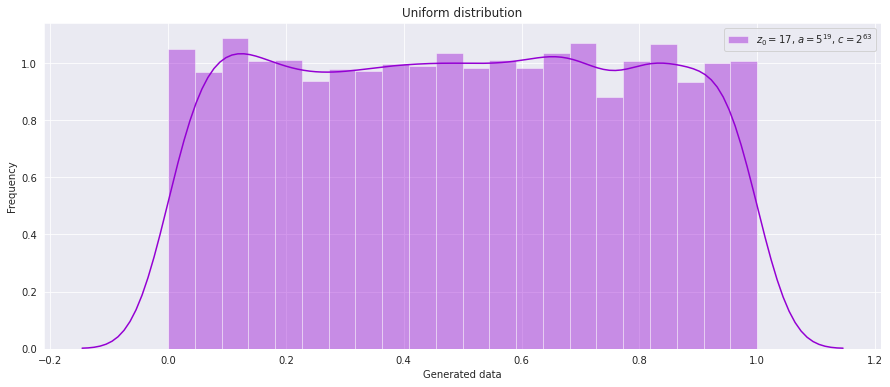

In [100]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

sns.distplot(x_uniform, ax=ax, color='darkviolet', label='$z_0 = 17$, $a = 5^{19}$, $c = 2^{63}$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Uniform distribution');
ax.legend();

+ розподіл схожий на рівномірний
+ дані розподілені в інтервалі (0, 1)

**Перевіримо значення математичного сподівання та дисперсії, порівняємо з теоретичними:**

$M(\epsilon) = \int_0^1 x \,dx = \frac{1}{2}$

$D(\epsilon) = \int_0^1 (x - \frac{1}{2})^2 \,dx = \frac{1}{12}$

In [91]:
print('M(epsilon) = %s\nD(epsilon) = %s' % (x_uniform.mean(), x_uniform.std(ddof=1)**2))

M(epsilon) = 0.49829352325505827
D(epsilon) = 0.08385442915042123


+ значення математичного очікування та дисперсії подібні до теоретичних

**Давайте знайдемо параметри даного розподілу:**

In [102]:
b_obs = x_uniform.mean() + np.sqrt(3)*x_uniform.std(ddof=1)
a_obs = 2*x_uniform.mean() - b_obs

print(f'a_obs = {round(a_obs, 5)}, b_obs = {round(b_obs, 5)}')

a_obs = -0.00327, b_obs = 0.99985


#### 3. Виконаємо перевірку на відповідність нормальному закону розподілу, використавши формулу:

$f(x) = \frac{1}{b - a}$, $a \leq x \leq b$

In [93]:
def uniform_pdf(x, a, b):
    """
        Probability density function
    """
    return (1/(b-a))*((x >= a) & (x <= b)) # f

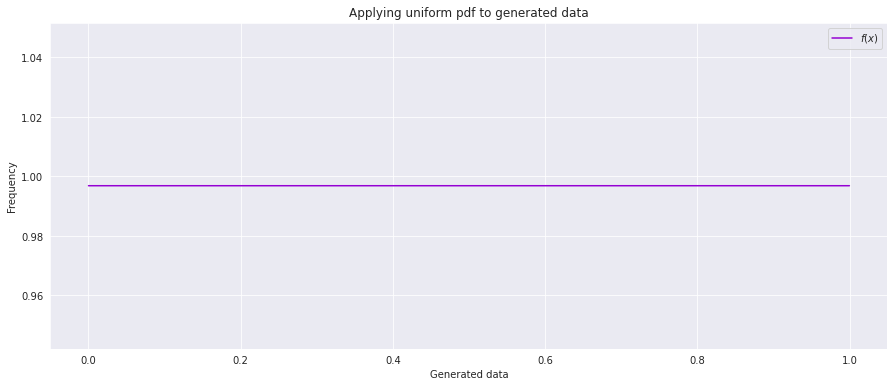

In [94]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

x = np.linspace(0,1,100000)
sns.lineplot(x_uniform, uniform_pdf(x_uniform, a_obs, b_obs), ax=ax, color='darkviolet', label='$f(x)$')

ax.set_xlabel(u'Generated data')
# ax.set_xlim(0, 200)
ax.set_ylabel(u'Frequency')
ax.set_title(u'Applying uniform pdf to generated data');
ax.legend();

#### 4. Відповідність заданому закону розподілу перевірити за допомогою критерію $\chi^2$

$H_0:$ дані мають рівномірний розподіл з заданим параметром $a$ та $b$

$H_1: H_0$ не виконується

In [104]:
observed_freq, expected_freq = create_bins_uniform(x_uniform)

In [96]:
stat_val, p_value = stats.chisquare(list(observed_freq.values()), list(expected_freq.values()), ddof=2)

+ **Ймовірність отримати значення статистики як в експерименті чи ще більше екстримальне при справедливості нульової гіпотези**
+ **Чим нижче p-value, тим сильніше дані свідчать проти прийняття нульової гіпотези на користь альтернативи**

$p = P(T \geq t|H_0)$

In [97]:
alpha = 0.05
if p_value < alpha:
    print(f'Не можемо прийняти нульову гіпотезу на рівні значемості alpha={alpha}.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))
else:
    print('Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.')
    print('Значення статистики:')
    print('\t- stat_val = %s\n\t- p-value = %s' % (round(stat_val, 5), round(p_value, 5)))

Можемо прийняти нульову гіпотезу про розподіл данних з заданим параметром.
Значення статистики:
	- stat_val = 32.16884
	- p-value = 0.22589
